In [153]:
# carga, visualizacion  y preprocesamiento de datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import plotly.express as px
# modelos
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
# evaluacion de modelos
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
# opciones de display
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

# ¿Qué características de un país influyen en su producción de energías bajas en carbono?

En esta notebook:
- preparamos los datos para realizar una regresión (selección de variables, eliminación de outliers, creación de arrays X e y)
- corremos 3 modelos exploratorios para seleccionar el que ajuste mejor: regresión lineal, regresión con random forest, regresión con SVR. 
- una vez seleccionado el modelo de mejor ajuste (random forest), optimizamos los hiperparámetros del mismo

## Carga y preprocesamiento de datos

Cargamos los datos y observamos el dataframe

In [154]:
wec = pd.read_csv(r'../datasets/wec_reg_lineal')  
wec.head(10)

,country,continente,year,population,low_carbon_electricity,nivel_ingresos
0,Afghanistan,Asia,2011,30.117,0.595,bajo
1,Afghanistan,Asia,2012,31.161,0.738,bajo
2,Afghanistan,Asia,2013,32.270,0.885,bajo
3,Afghanistan,Asia,2014,33.371,1.000,bajo
4,Afghanistan,Asia,2015,34.414,1.034,bajo
5,Afghanistan,Asia,2016,35.383,1.060,bajo
6,Afghanistan,Asia,2017,36.296,1.088,bajo
7,Afghanistan,Asia,2018,37.172,0.965,bajo
8,Afghanistan,Asia,2019,38.042,0.880,bajo
9,Albania,Europa,2011,2.929,4.091,medio-alto


In [155]:
# Se consultan los datos únicos que integran la columna country 
n_paises = len(wec['country'].unique())
print(f"Contamos con datos de {n_paises} países.")

Contamos con datos de 204 países.


Creamos la columna con la que trabajaremos: **energía baja en carbono producida per cápita (teravatios-hora/habitante)**

In [156]:

wec["lc_per_capita"] = wec["low_carbon_electricity"]/wec["population"]

Visualizamos los datos:

In [157]:
fig = px.scatter(x=wec["population"], y=wec["lc_per_capita"], color=wec["country"])
# Especificamos el diseño del gráfico
fig.update_layout(
    xaxis_title='Población (millones de habitantes)',
    yaxis_title='Producción per capita (teravatios-hora/habitante)',
    title='Producción de electricidad low-carbon per capita en funcion de la población',
)
fig.show()

In [158]:
wec.sort_values("population", ascending= False)

,country,continente,year,population,low_carbon_electricity,nivel_ingresos,lc_per_capita
350,China,Asia,2019,1433.784064,2391.958,medio-alto,1.668283
349,China,Asia,2018,1427.648000,2164.900,medio-alto,1.516410
348,China,Asia,2017,1421.021952,1942.300,medio-alto,1.366833
347,China,Asia,2016,1414.049024,1760.900,medio-alto,1.245289
346,China,Asia,2015,1406.848000,1563.200,medio-alto,1.111136
...,...,...,...,...,...,...,...
1200,Niue,Oceanía,2014,0.002000,0.000,alto,0.000000
1199,Niue,Oceanía,2013,0.002000,0.000,alto,0.000000
1198,Niue,Oceanía,2012,0.002000,0.000,alto,0.000000
1197,Niue,Oceanía,2011,0.002000,0.000,alto,0.000000


Descartamos los países India y China porque hemos corroborado en un análisis previo que son outliers respecto de la población. 

In [159]:
wec = wec[wec["country"] != "China"]
wec = wec[wec["country"] != "India"]

## Definicion de variables predictoras y variable respuesta. 

Seleccionamos nuestras variables predictoras o explicativas (var_predict) y nuestra variable respuesta que queremos proyectar (var_respuesta).

In [160]:
predictoras = ['population', 'continente', 
              'nivel_ingresos', 'year']
respuesta = 'lc_per_capita'


Realizamos encoding de las columnas predictoras categoricas dado que el modelo no acepta variables de tipo stirng. 

In [161]:
wec_encoded = pd.get_dummies(wec[predictoras], drop_first=True)

Definimos las variables X e y para la regresión y verificamos su forma. 

In [162]:
X = wec_encoded
y = wec[respuesta]
X.shape, y.shape

((1818, 10), (1818,))

Eliminamos datos que se encuentren por encima del percentil 75 y por debajo del percentil 25  dado que en un análisis previo corrobnoramos que el modelo ajusta mejor (no mostrado).

In [163]:
# Calculate the interquartile range (IQR)
Q1 = np.percentile(y, 25)
Q3 = np.percentile(y, 75)
IQR = Q3 - Q1

# Define the lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Keep only data points within the bounds
filtered_data = ((y >= lower_bound) & (y <= upper_bound))

# Use the filtered data for linear regression
x_filtered = X[filtered_data]
y_filtered = y[filtered_data]

Graficamos en función de la población para observar los datos sin outliers:

In [164]:
fig = px.scatter(x=x_filtered["population"], y=y_filtered)
fig.show()

Verificamos la forma de los datos sin outliers:

In [165]:
x_filtered.shape, y_filtered.shape

((1649, 10), (1649,))

Convertimos en array:

In [166]:
x, y = np.array(x_filtered), np.array(y_filtered)

Separamos dataset en datos de training y de testing. <br>
Entrenaremos con 80% de los datos y testeareamos con el 20% de los datos.

In [167]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=42)

In [168]:
X_train

array([[0.401, 2014, False, ..., False, False, False],
       [2.877, 2011, False, ..., False, False, True],
       [10.526, 2012, True, ..., False, False, False],
       ...,
       [0.519, 2011, True, ..., False, False, False],
       [48.483, 2013, False, ..., False, True, False],
       [216.564992, 2019, False, ..., False, True, False]], dtype=object)

In [169]:
X_train.shape

(1319, 10)

In [170]:
y_test.shape

(330,)

## Funciones de evaluación y optimización de modelos

Definimos algunas funciones que usaremos para encontrar el mejor modelo.

In [171]:
def graph_real_pred(y_test, predictions, color):
    """
    Funcion que grafica los valores reales vs. predichos
    :param y_test: valores reales
    :param predictions: valores predichos
    :param color: color para el plot.

    :return: Scatterplot mostrando la relacion entre el valor real y el predicho
    """
    plt.scatter(y_test, predictions, c=color, s=10)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel('Valor real', size=15, labelpad=1)
    plt.ylabel('Valor predicho', size=15, labelpad=1)
   

In [172]:
# Se consultan los hiperparámetros más importantes
def feature_importance(model, feature_list):
    """
    Function that gets and plots the feature importance
    for the given model
    :param model: the model to evaluaate
    :param feature_list: a list of features contained in the model

    :returns a plot with feature importance
    """
    # Obtiene la lista de importancias
    importances = list(model.feature_importances_)
    # Junta los nombres de los atributos y las importancias
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    # Ordena por orden de importancia
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print la lista de importancias
    [print('Variable: {} Importance: {}'.format(*pair)) for pair in feature_importances];
    # Colores
    colors = cm.rainbow(np.linspace(0, 1, len(feature_list)))

    # Caracteristicas en orden de importancia
    characteristics = [x[0] for x in feature_importances]
    # Obtiene las importancias
    importances_plot = [x[1] for x in feature_importances]
    # Grafica un bar plot
    plt.figure(figsize=(25,6))
    plt.bar(characteristics, importances_plot, color=colors)
    # Personalizamos el grafico
    plt.xticks(list(range(len(characteristics))), characteristics, rotation = 90)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gcf().subplots_adjust(bottom=0.3);

## Modelos exploratorios

### Modelo 1: Regresión lineal

In [173]:
regresor1 = LinearRegression()
regresor1.fit(X_train, y_train)

LinearRegression()

In [174]:
y_pred1 = regresor1.predict(X_test)

In [175]:
print(regresor1.intercept_)

-16.788320016761077


In [176]:
print(regresor1.coef_)

[ 0.00198605  0.00858565  0.94136093 -0.1976983  -0.09397638  0.56521794
 -0.28124315 -0.25277462 -0.13680529  0.14743797]


Evaluamos metricas del modelo

In [177]:
r1 = r2_score(y_test, y_pred1)
r1

0.3487646437452818

In [178]:
mae1 = mean_absolute_error(y_test, y_pred1)
mae1

0.42168721107543977

### Modelo 2: Random Forest

In [179]:
# Se inicia el modelo
regresor_rf = RandomForestRegressor(criterion='absolute_error', random_state=42, n_estimators = 1000)

In [180]:
# Se entrena el modelo
regresor_rf.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', n_estimators=1000,
                      random_state=42)

In [181]:
regresor_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'absolute_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [182]:
# Se predicen los valores para el set de testeo
y_pred_rf = regresor_rf.predict(X_test)

In [183]:
r2 = r2_score(y_test, y_pred_rf)
r2

0.8165837205523471

In [184]:
# Se calcula el error medio absoluto
mae2 = mean_absolute_error(y_test, y_pred_rf)
mae2

0.1523359556544264

### Modelo 3: Support Vector Machine

In [185]:
# Se inicia el modelo
regresor_svr = SVR(C=1.0, epsilon=0.2)

In [186]:
# Se entrena el modelo
regresor_svr.fit(X_train, y_train)

SVR(epsilon=0.2)

In [187]:
regresor_svr.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.2,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [188]:
#Se predicen los valores para el set de testeo
y_pred_svr = regresor_svr.predict(X_test)

In [189]:
# Se calcula el error medio absoluto
mae3 = mean_absolute_error(y_test, y_pred_svr)
mae3

0.4842433375492618

In [190]:
r3 = r2_score(y_test, y_pred_svr)
r3

-0.10725443759621855

## Comparación de modelos

#### Gráfico de reales vs predichos

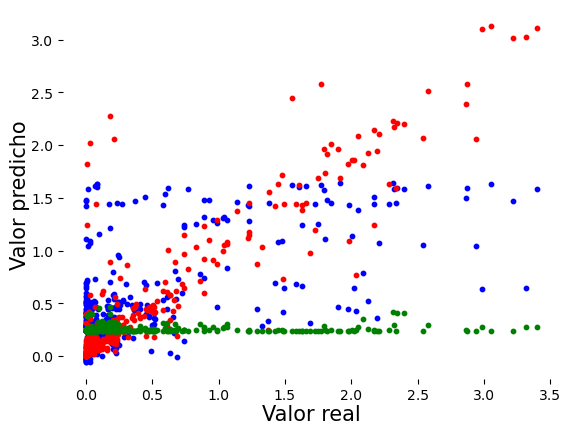

In [191]:
graph_real_pred(y_test, y_pred1, color="b")
graph_real_pred(y_test, y_pred_rf, color="r")
graph_real_pred(y_test, y_pred_svr, color="g")
plt.show()

#### Qué modelo tiene el menor error absoluto medio?

In [192]:
mae1, mae2, mae3

(0.42168721107543977, 0.1523359556544264, 0.4842433375492618)

#### Qué modelo ajusta mejor a una recta?

In [193]:
r1, r2, r3

(0.3487646437452818, 0.8165837205523471, -0.10725443759621855)

Vemos que el modelo 2 (con random forest) presenta el mejor ajuste y el menor error, asique continuaremos con random forest, buscando los hiperparámtros óptimos.

## Búsqueda del mejor estimador

In [194]:
# Valores para los parametros a optimizar
param_grid_rf = {
    'criterion': ['absolute_error'],
    'n_estimators': [70, 80, 90, 100, 120],
    'max_features': ['log2','sqrt'],
    'max_depth': [1, 3, 5, 10, 20, 50],
    'min_samples_leaf': [1, 3, 5, 10, 20, 50]
}

In [195]:
# Inicializamos un modelo
grid_regresor = RandomForestRegressor(random_state=42)

In [196]:
# Creamos la busqueda
rf_search = GridSearchCV(estimator=grid_regresor, param_grid=param_grid_rf,
                         cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

In [197]:
# Corremos el gridsearch con una validación usando 3 folds.
rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['absolute_error'],
                         'max_depth': [1, 3, 5, 10, 20, 50],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10, 20, 50],
                         'n_estimators': [70, 80, 90, 100, 120]},
             scoring='neg_mean_absolute_error', verbose=2)

In [198]:
rf_search.best_estimator_

RandomForestRegressor(criterion='absolute_error', max_depth=20,
                      max_features='log2', n_estimators=90, random_state=42)

In [199]:
rf_search.best_params_

{'criterion': 'absolute_error',
 'max_depth': 20,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'n_estimators': 90}

In [200]:
rf_search.best_score_

-0.28964122491548266

In [201]:
# Asignamos el mejor estimador a mejor_regresor
mejor_regresor = RandomForestRegressor(criterion='absolute_error', n_estimators=100, max_depth=20, max_features='log2', min_samples_leaf=1)

In [202]:
# Entrenamos el modelo
mejor_regresor.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=20,
                      max_features='log2')

In [203]:
# Hacemos la prediccion para el test de evaluación
predicciones = mejor_regresor.predict(X_test)

### Evaluación de métricas del modelo

#### Error absoluto medio

In [204]:
mae4 = mean_absolute_error(y_test, predicciones)
mae4

0.2530036123208939

#### R cuadrado

In [205]:
r4 = r2_score(y_test, predicciones)
r4

0.6798824217681683

#### Reales vs predichos

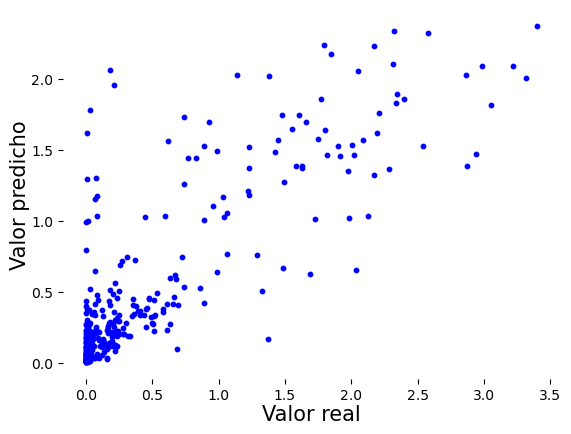

In [206]:
# Correlacion
graph_real_pred(y_test, predicciones, color="b")

## Feature importance

Variable: population Importance: 0.56
Variable: nivel_ingresos Importance: 0.16
Variable: continente Importance: 0.09
Variable: year Importance: 0.01


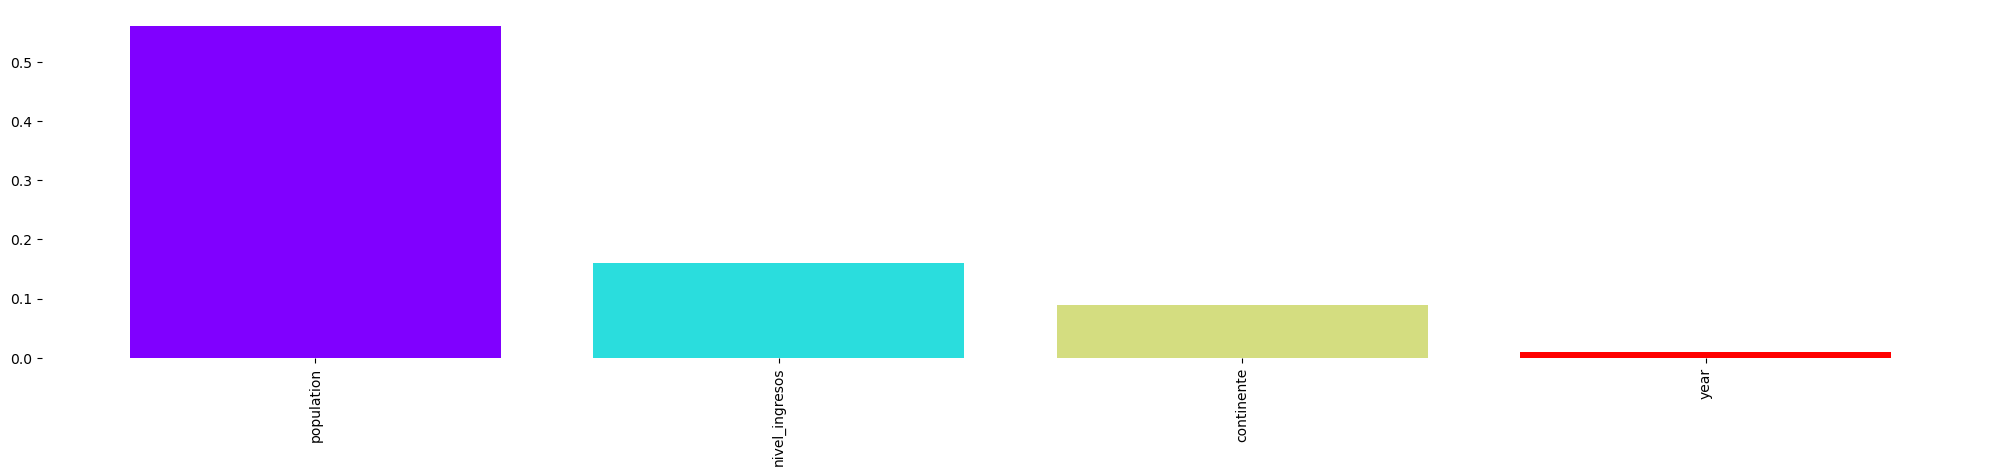

In [207]:
# Importancia de cada feature
feature_importance(mejor_regresor, predictoras)

Vemos que las variables con mayor impacto en la producción de energía low_carbon de un país son su población y su nivel de ingresos, con menores aportes del contienente y casi sin aporte del año.

## Conclusiones

Pudimos correr varios modelos de regresión y seleccionar el algoritmo de mejor ajuste, para luego optimizar sus hiperparámetros. <br>
Pudimos determinar algunas de las variables que impactan en la producción low-carbon de un país. 